In [1]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder
le = LabelEncoder()


# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

# Fit the LabelEncoder and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create a PyTorch dataset
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

# Initialize the model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Create the trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics, 
)

2024-02-08 06:51:17.663674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 06:51:17.663781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 06:51:17.836149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
trainer.train()
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_35/1280658943.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.327400
1000,0.184300
1500,0.139300
2000,0.123600
2500,0.079700
3000,0.064500
3500,0.070200
4000,0.054000
4500,0.033700
5000,0.027000


/tmp/ipykernel_35/1280658943.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/ipykernel_35/1280658943.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars

eval_loss: 0.08897167444229126
eval_accuracy: 0.9825646098676889
eval_precision: 0.994215291750503
eval_recall: 0.9710144927536232
eval_f1: 0.98247794209022
eval_runtime: 134.9959
eval_samples_per_second: 59.906
eval_steps_per_second: 0.941
epoch: 3.0


In [ ]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute AUC-ROC
auc = roc_auc_score(labels, predictions)

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [13]:
TOKENIZERS_PARALLELISM= False

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
# Load some text data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

import warnings

# Ignore user warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder
le = LabelEncoder()


# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

# Create a count vectorizer
vectorizer = CountVectorizer()

# Transform the training data to document-term matrix
X_train_counts = vectorizer.fit_transform(X_train)

# Train a MultinomialNB model
nb = MultinomialNB()
nb.fit(X_train_counts, y_train)

# Compute the log-count ratios
log_count_ratio = nb.feature_log_prob_[1] - nb.feature_log_prob_[0]

# Create new features for the SVM
X_train_features = X_train_counts.multiply(log_count_ratio)

# Train a LinearSVC model
svm = LinearSVC()
svm.fit(X_train_features, y_train)

# Transform the test data to document-term matrix
X_test_counts = vectorizer.transform(X_test)

# Create new features for the SVM
X_test_features = X_test_counts.multiply(log_count_ratio)

# Evaluate the model
print("Test Accuracy: ", svm.score(X_test_features, y_test))

Test Accuracy:  0.8900704834920242


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Generate predictions
predictions = svm.predict(X_test_features)

# Compute accuracy
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: ', accuracy)

# Compute precision
precision = precision_score(y_test, predictions, average='weighted')
print('Precision: ', precision)

# Compute recall
recall = recall_score(y_test, predictions, average='weighted')
print('Recall: ', recall)

# Compute F1 score
f1 = f1_score(y_test, predictions, average='weighted')
print('F1 Score: ', f1)

Accuracy:  0.8900704834920242
Precision:  0.8907036979651695
Recall:  0.8900704834920242
F1 Score:  0.8900426836885172


In [9]:
import numpy as np
print(np.unique(y_test))

['CG' 'OR']


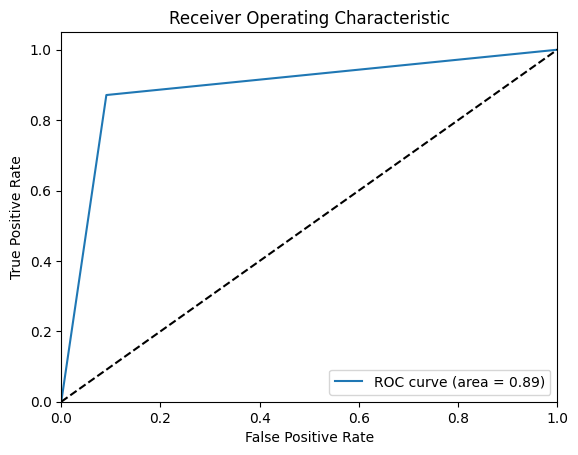

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Binarize labels and predictions
labels = y_test
labels_bin = label_binarize(labels, classes=['CG', 'OR'])
predictions_bin = label_binarize(predictions, classes=['CG', 'OR'])

# Compute AUC-ROC
auc = roc_auc_score(labels_bin, predictions_bin, average='macro')

# Compute ROC curve for each class
fpr, tpr, _ = roc_curve(labels_bin.ravel(), predictions_bin.ravel())

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

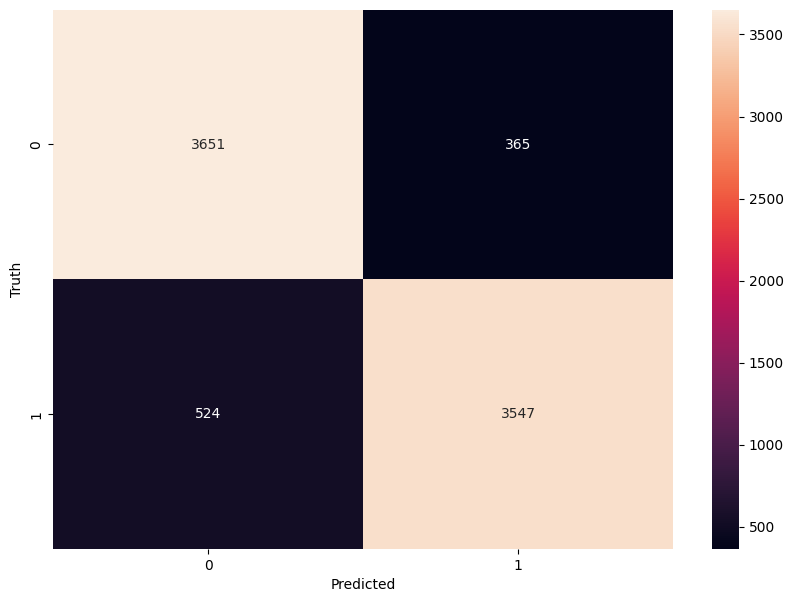

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)
# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [1]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder



# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)
le = LabelEncoder()

tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

tokenizer.pad_token = tokenizer.eos_token

if not tokenizer.pad_token:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

# Now you can tokenize your texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)


# Convert to Dataset
train_dataset = FakeReviewDataset(train_encodings, train_labels)
test_dataset = FakeReviewDataset(test_encodings, test_labels)


model = GPT2ForSequenceClassification.from_pretrained("distilgpt2")

# Define a padding token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# Create the Trainer
training_args = TrainingArguments(
    output_dir='gptresults',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='gptlogs',
    gradient_accumulation_steps=2,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

2024-02-08 20:39:52.113955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 20:39:52.114061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 20:39:52.288868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/tmp/ipykernel_34/646881298.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).float()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.214800
1000,0.062700
1500,0.029600
2000,0.023100
2500,0.014300
3000,0.010800


/tmp/ipykernel_34/646881298.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).float()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/tmp/ipykernel_34/646881298.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).float()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensor

TrainOutput(global_step=3033, training_loss=0.058730317948480035, metrics={'train_runtime': 6180.0142, 'train_samples_per_second': 15.701, 'train_steps_per_second': 0.491, 'total_flos': 2.374591518722304e+16, 'train_loss': 0.058730317948480035, 'epoch': 3.0})

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

/tmp/ipykernel_34/646881298.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx]).float()


eval_loss: 0.019722625613212585
eval_accuracy: 0.4965994806479535
eval_precision: 0.0
eval_recall: 0.0
eval_f1: 0.0
eval_runtime: 159.1809
eval_samples_per_second: 50.804
eval_steps_per_second: 0.798
epoch: 3.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')
# Initialize the LabelEncoder

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].unsqueeze(0)  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)

# Split your data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)
le = LabelEncoder()

# Fit and transform the labels
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# Now you can convert your labels to tensors
train_labels = torch.from_numpy(train_labels)
test_labels = torch.from_numpy(test_labels)

train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


train_dataset = FakeReviewDataset(train_encodings, train_labels)
test_dataset = FakeReviewDataset(test_encodings, test_labels)


# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,  # use the function defined in the previous step
)

# Train the model
trainer.train()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.249300
1000,0.097100
1500,0.043400
2000,0.035900
2500,0.011700
3000,0.008400


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=3033, training_loss=0.07362395172224476, metrics={'train_runtime': 4753.3248, 'train_samples_per_second': 20.414, 'train_steps_per_second': 0.638, 'total_flos': 2.55309812568576e+16, 'train_loss': 0.07362395172224476, 'epoch': 3.0})

In [4]:
import numpy as np
metrics = trainer.evaluate()

# Print the metrics
for key, value in metrics.items():
    print(f"{key}: {value}")

eval_loss: 0.10541250556707382
eval_accuracy: 0.9767528131569185
eval_precision: 0.9941460931534741
eval_recall: 0.9594694178334562
eval_f1: 0.9765
eval_runtime: 143.1178
eval_samples_per_second: 56.506
eval_steps_per_second: 0.447
epoch: 3.0


In [5]:
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import roc_auc_score, confusion_matrix

# Compute AUC-ROC
auc = roc_auc_score(labels, predictions)

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


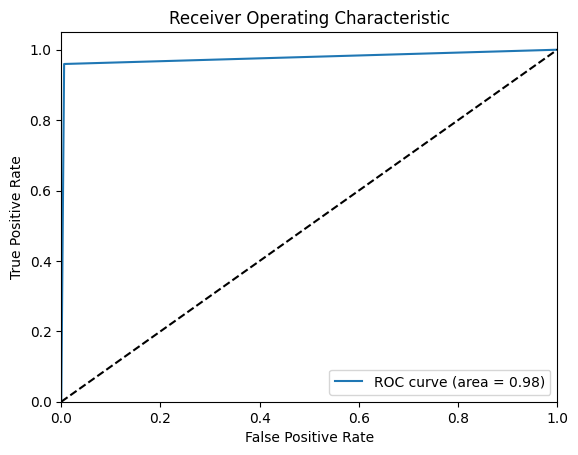

In [6]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

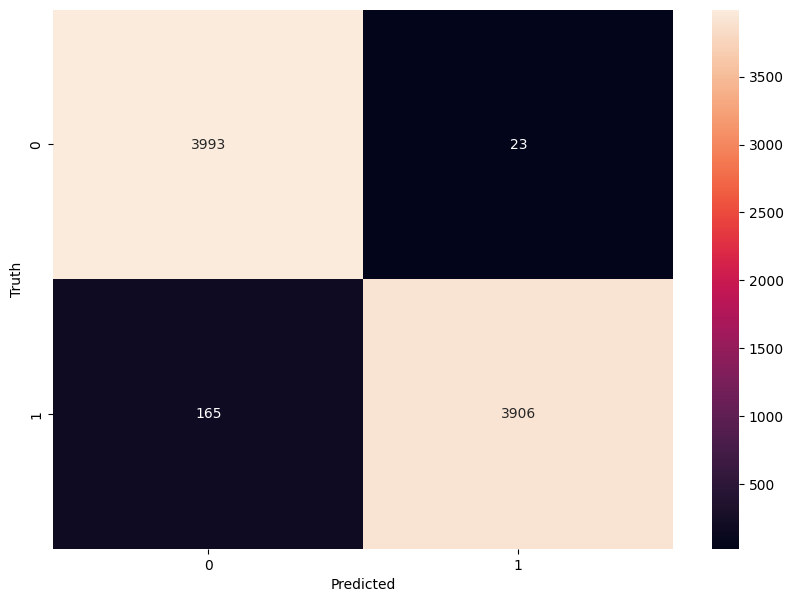

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Accuracy for Home_and_Kitchen_5: 0.9064039408866995
AUC-ROC for Home_and_Kitchen_5: 0.9058007964257964
Confusion matrix for Home_and_Kitchen_5:
 [[387  29]
 [ 47 349]]


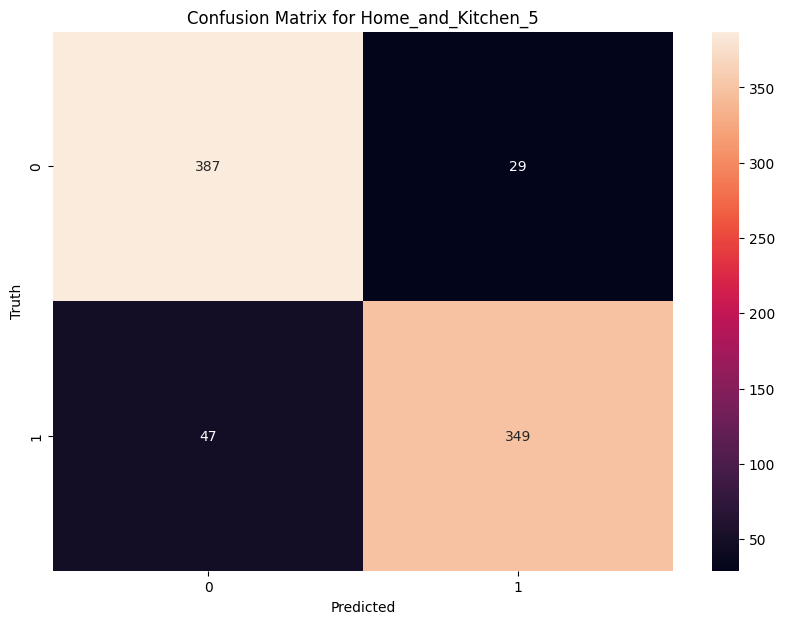

Classification report for Home_and_Kitchen_5:
               precision    recall  f1-score   support

          CG       0.89      0.93      0.91       416
          OR       0.92      0.88      0.90       396

    accuracy                           0.91       812
   macro avg       0.91      0.91      0.91       812
weighted avg       0.91      0.91      0.91       812

Accuracy for Sports_and_Outdoors_5: 0.9012658227848102
AUC-ROC for Sports_and_Outdoors_5: 0.9005748896417206
Confusion matrix for Sports_and_Outdoors_5:
 [[376  32]
 [ 46 336]]


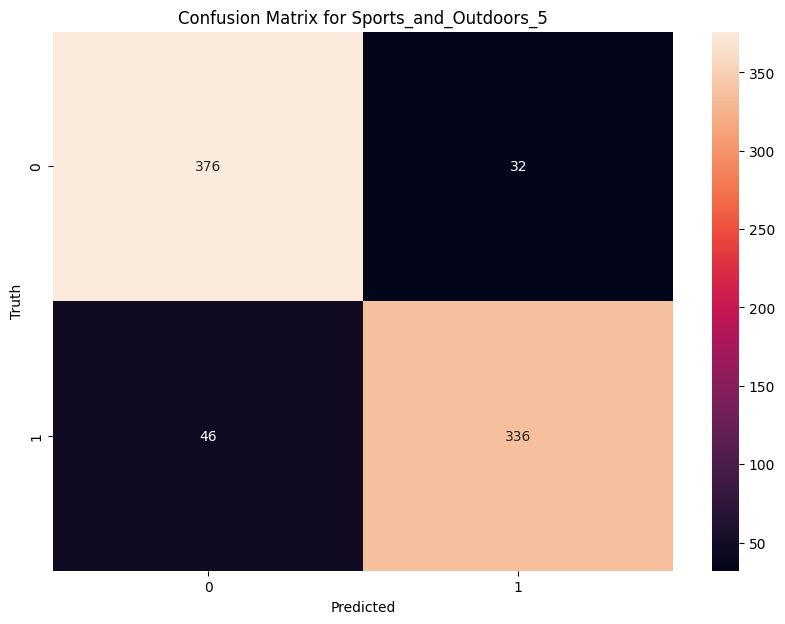

Classification report for Sports_and_Outdoors_5:
               precision    recall  f1-score   support

          CG       0.89      0.92      0.91       408
          OR       0.91      0.88      0.90       382

    accuracy                           0.90       790
   macro avg       0.90      0.90      0.90       790
weighted avg       0.90      0.90      0.90       790

Accuracy for Electronics_5: 0.9085213032581454
AUC-ROC for Electronics_5: 0.9082279078847111
Confusion matrix for Electronics_5:
 [[383  36]
 [ 37 342]]


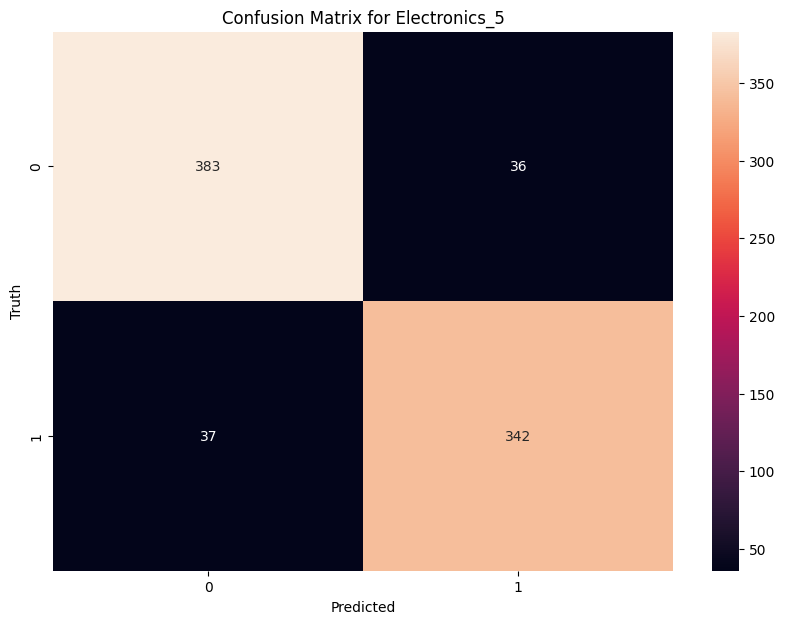

Classification report for Electronics_5:
               precision    recall  f1-score   support

          CG       0.91      0.91      0.91       419
          OR       0.90      0.90      0.90       379

    accuracy                           0.91       798
   macro avg       0.91      0.91      0.91       798
weighted avg       0.91      0.91      0.91       798

Accuracy for Movies_and_TV_5: 0.8760445682451253
AUC-ROC for Movies_and_TV_5: 0.8759316770186335
Confusion matrix for Movies_and_TV_5:
 [[324  44]
 [ 45 305]]


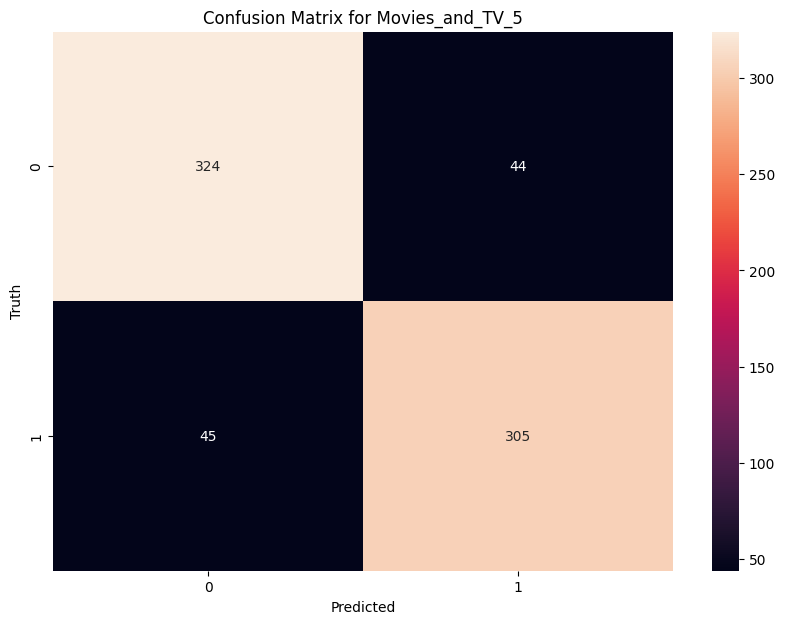

Classification report for Movies_and_TV_5:
               precision    recall  f1-score   support

          CG       0.88      0.88      0.88       368
          OR       0.87      0.87      0.87       350

    accuracy                           0.88       718
   macro avg       0.88      0.88      0.88       718
weighted avg       0.88      0.88      0.88       718

Accuracy for Tools_and_Home_Improvement_5: 0.8795336787564767
AUC-ROC for Tools_and_Home_Improvement_5: 0.8791771620486986
Confusion matrix for Tools_and_Home_Improvement_5:
 [[325  50]
 [ 43 354]]


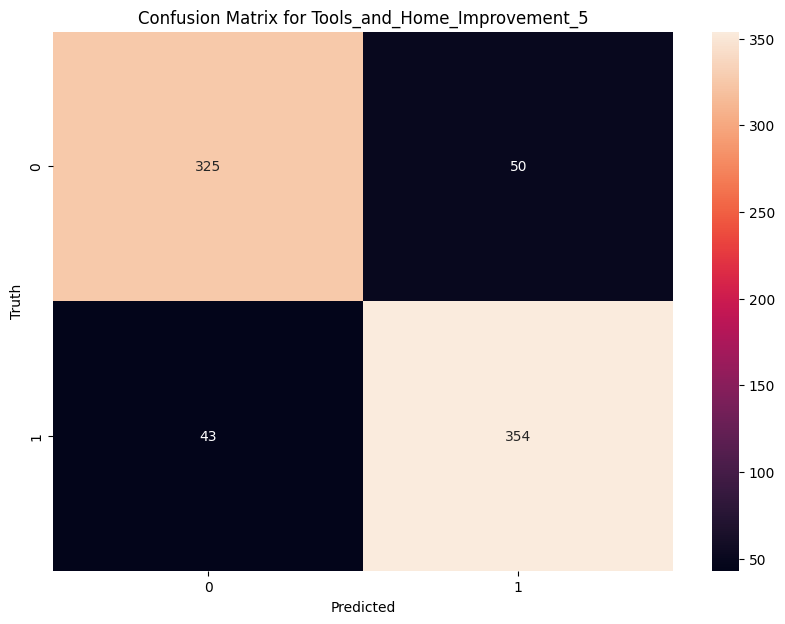

Classification report for Tools_and_Home_Improvement_5:
               precision    recall  f1-score   support

          CG       0.88      0.87      0.87       375
          OR       0.88      0.89      0.88       397

    accuracy                           0.88       772
   macro avg       0.88      0.88      0.88       772
weighted avg       0.88      0.88      0.88       772

Accuracy for Pet_Supplies_5: 0.8907168037602821
AUC-ROC for Pet_Supplies_5: 0.8904578803146823
Confusion matrix for Pet_Supplies_5:
 [[392  40]
 [ 53 366]]


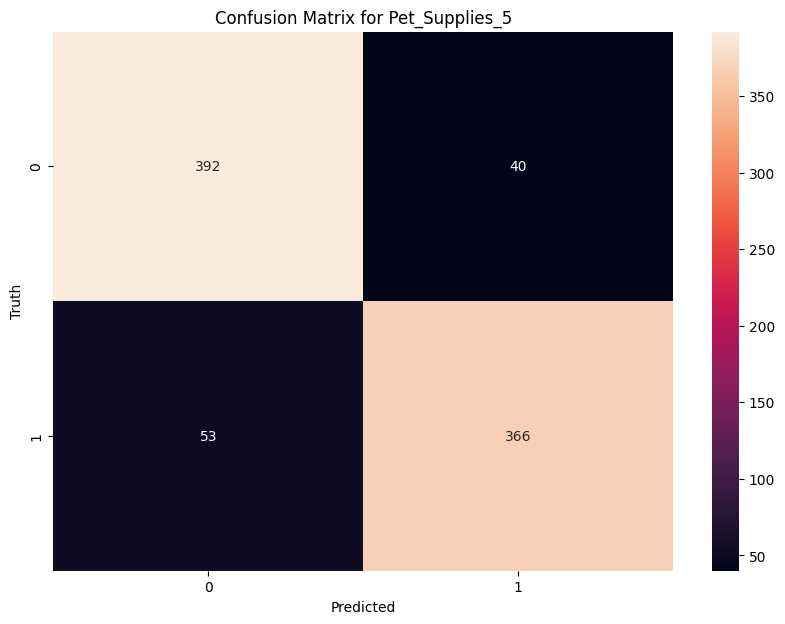

Classification report for Pet_Supplies_5:
               precision    recall  f1-score   support

          CG       0.88      0.91      0.89       432
          OR       0.90      0.87      0.89       419

    accuracy                           0.89       851
   macro avg       0.89      0.89      0.89       851
weighted avg       0.89      0.89      0.89       851

Accuracy for Kindle_Store_5: 0.9016913319238901
AUC-ROC for Kindle_Store_5: 0.9021861587982832
Confusion matrix for Kindle_Store_5:
 [[436  30]
 [ 63 417]]


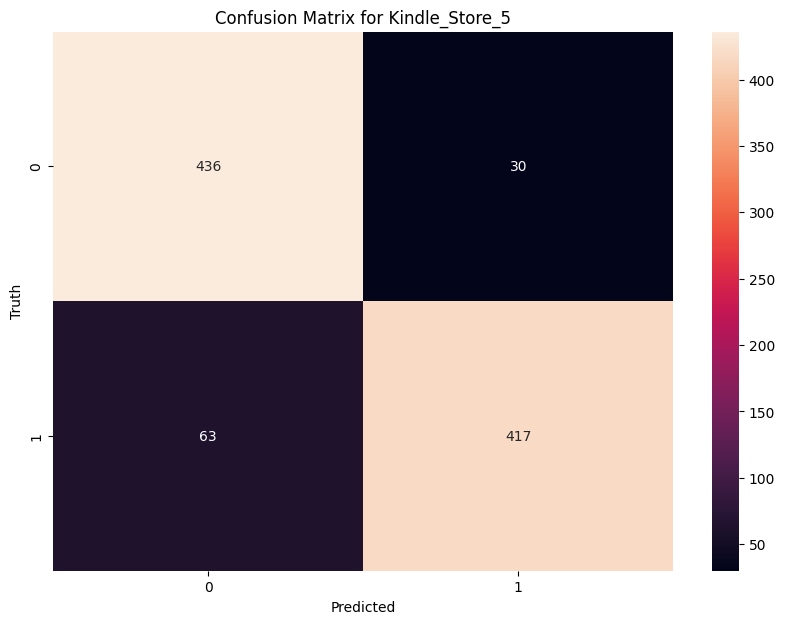

Classification report for Kindle_Store_5:
               precision    recall  f1-score   support

          CG       0.87      0.94      0.90       466
          OR       0.93      0.87      0.90       480

    accuracy                           0.90       946
   macro avg       0.90      0.90      0.90       946
weighted avg       0.90      0.90      0.90       946

Accuracy for Books_5: 0.8775743707093822
AUC-ROC for Books_5: 0.8774512884978001
Confusion matrix for Books_5:
 [[393  51]
 [ 56 374]]


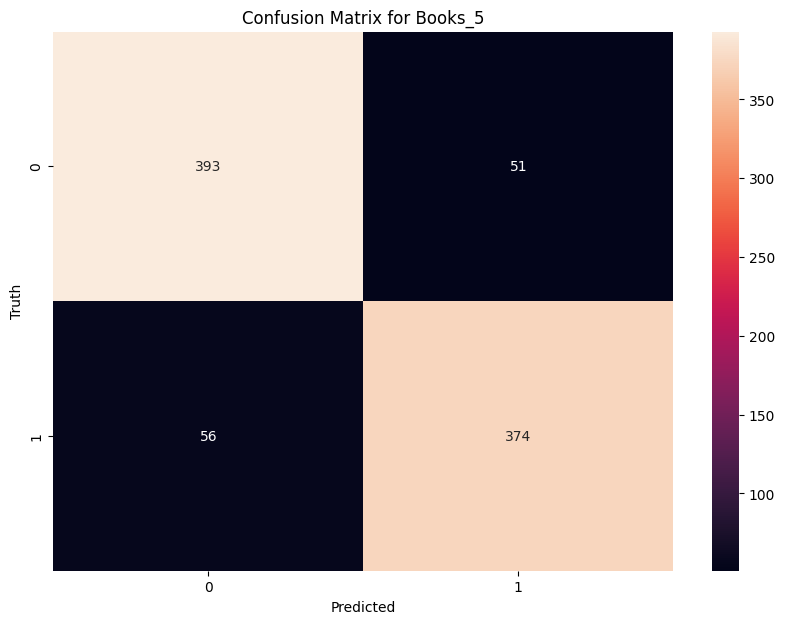

Classification report for Books_5:
               precision    recall  f1-score   support

          CG       0.88      0.89      0.88       444
          OR       0.88      0.87      0.87       430

    accuracy                           0.88       874
   macro avg       0.88      0.88      0.88       874
weighted avg       0.88      0.88      0.88       874

Accuracy for Toys_and_Games_5: 0.9025032938076416
AUC-ROC for Toys_and_Games_5: 0.9025198294183834
Confusion matrix for Toys_and_Games_5:
 [[337  36]
 [ 38 348]]


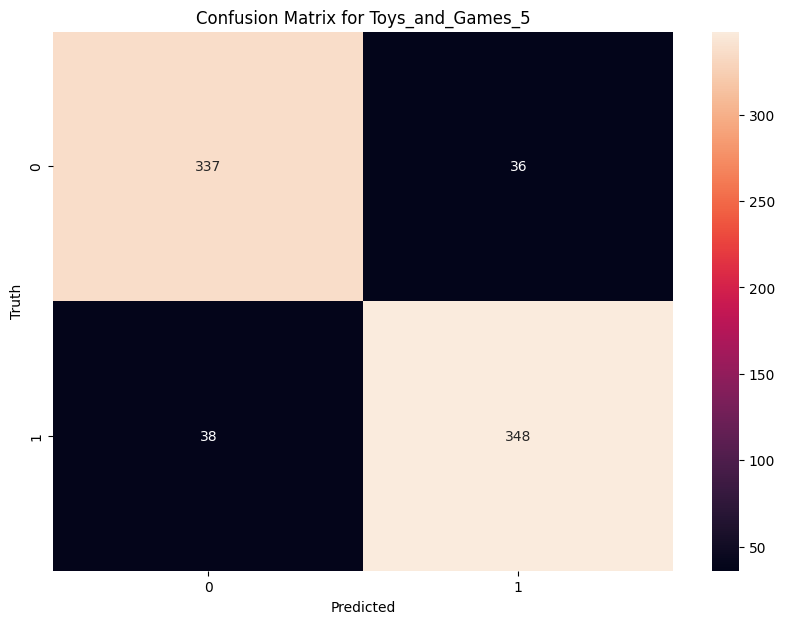

Classification report for Toys_and_Games_5:
               precision    recall  f1-score   support

          CG       0.90      0.90      0.90       373
          OR       0.91      0.90      0.90       386

    accuracy                           0.90       759
   macro avg       0.90      0.90      0.90       759
weighted avg       0.90      0.90      0.90       759

Accuracy for Clothing_Shoes_and_Jewelry_5: 0.8883116883116883
AUC-ROC for Clothing_Shoes_and_Jewelry_5: 0.8885543795226266
Confusion matrix for Clothing_Shoes_and_Jewelry_5:
 [[346  48]
 [ 38 338]]


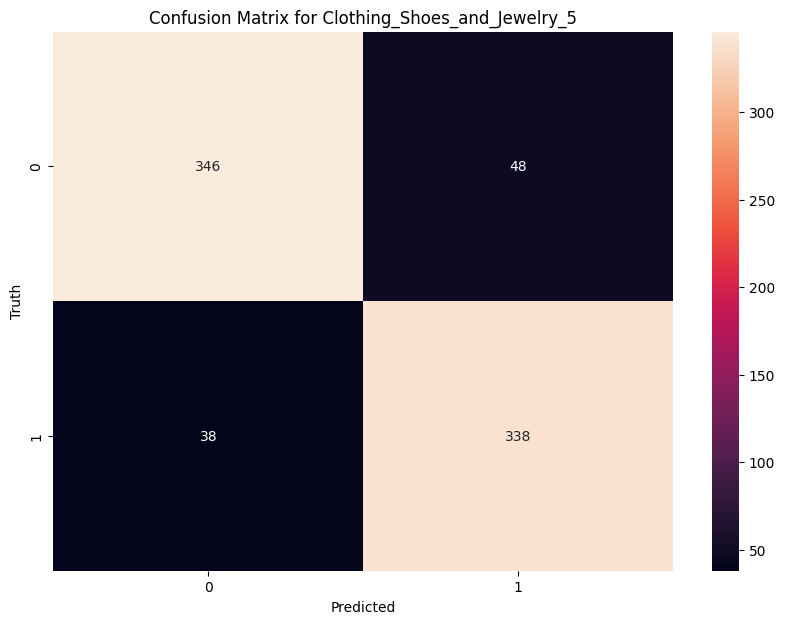

Classification report for Clothing_Shoes_and_Jewelry_5:
               precision    recall  f1-score   support

          CG       0.90      0.88      0.89       394
          OR       0.88      0.90      0.89       376

    accuracy                           0.89       770
   macro avg       0.89      0.89      0.89       770
weighted avg       0.89      0.89      0.89       770



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Load your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')

# List of categories
categories = df['category'].unique()

# Initialize a CountVectorizer
vectorizer = CountVectorizer()

# Loop over each category
for category in categories:
    # Filter data for the current category
    df_filtered = df[df['category'] == category]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Vectorize the reviews
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Train model
    model = LogisticRegression()
    model.fit(X_train_vec, y_train)

    # Make predictions
    predictions = model.predict(X_test_vec)

    # Compute accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy for {category}:', accuracy)
    
    
    # Compute AUC-ROC
    y_test_bin = label_binarize(y_test, classes=['CG', 'OR'])
    predictions_bin = label_binarize(predictions, classes=['CG', 'OR'])
    auc_score = roc_auc_score(y_test_bin, predictions_bin)
    print(f'AUC-ROC for {category}:', auc_score)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions)
    print(f'Confusion matrix for {category}:\n', cm)

    # Plot confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f'Confusion Matrix for {category}')
    plt.show()

    # Compute precision, recall, F1 score
    report = classification_report(y_test, predictions)
    print(f'Classification report for {category}:\n', report)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Category Home_and_Kitchen_5


Step,Training Loss


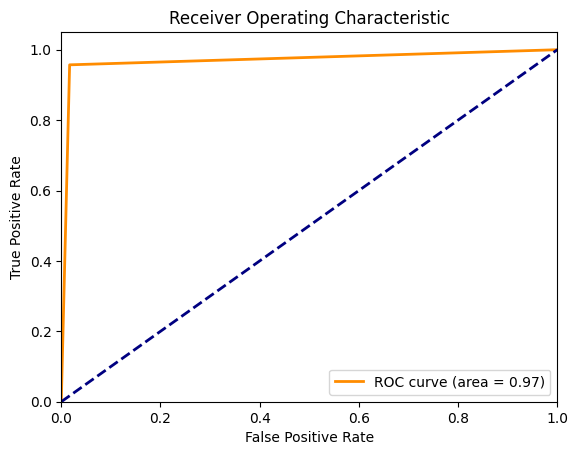

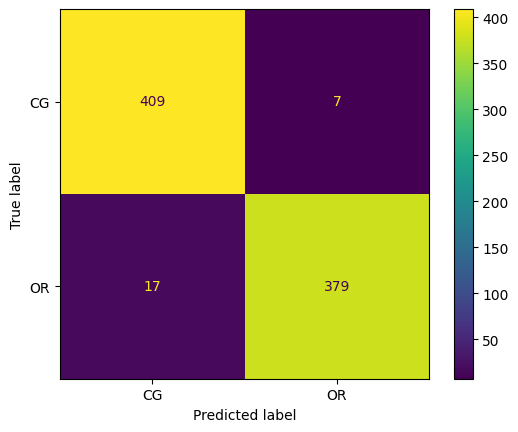

eval_loss: 0.08118601888418198
eval_accuracy: 0.9704433497536946
eval_f1: 0.969309462915601
eval_precision: 0.9818652849740933
eval_recall: 0.9570707070707071
eval_runtime: 17.1743
eval_samples_per_second: 47.28
eval_steps_per_second: 0.408
epoch: 3.0
Category Sports_and_Outdoors_5


Step,Training Loss


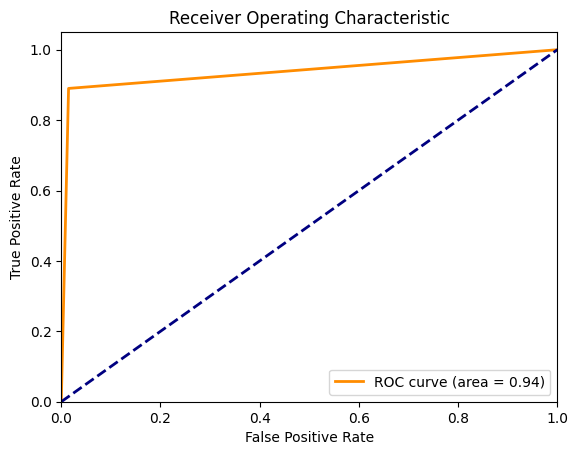

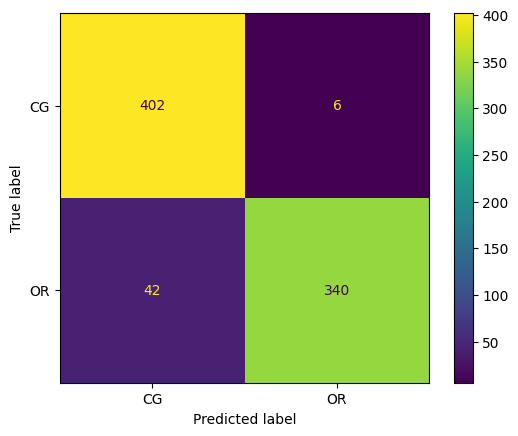

eval_loss: 0.24375596642494202
eval_accuracy: 0.9392405063291139
eval_f1: 0.9340659340659341
eval_precision: 0.9826589595375722
eval_recall: 0.8900523560209425
eval_runtime: 16.0183
eval_samples_per_second: 49.319
eval_steps_per_second: 0.437
epoch: 3.0
Category Electronics_5


Step,Training Loss


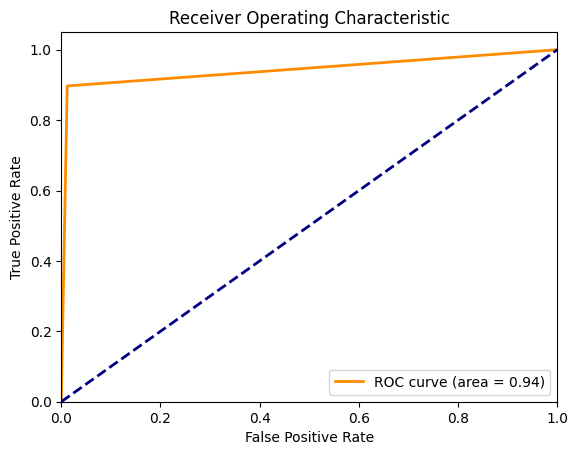

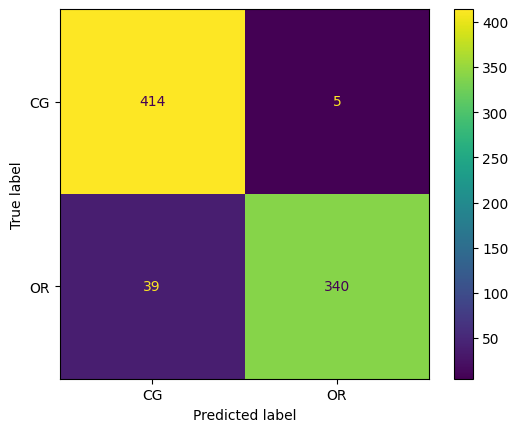

eval_loss: 0.2283450812101364
eval_accuracy: 0.9448621553884712
eval_f1: 0.9392265193370165
eval_precision: 0.9855072463768116
eval_recall: 0.8970976253298153
eval_runtime: 16.2299
eval_samples_per_second: 49.169
eval_steps_per_second: 0.431
epoch: 3.0
Category Movies_and_TV_5


Step,Training Loss


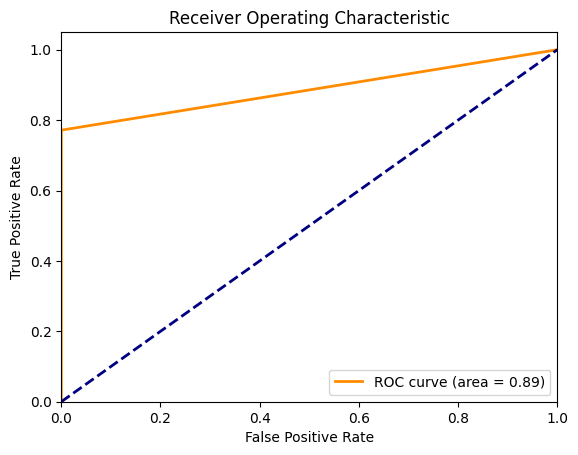

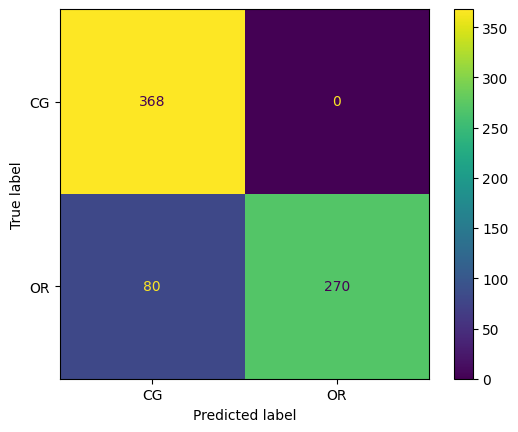

eval_loss: 0.6116952300071716
eval_accuracy: 0.8885793871866295
eval_f1: 0.870967741935484
eval_precision: 1.0
eval_recall: 0.7714285714285715
eval_runtime: 14.6054
eval_samples_per_second: 49.16
eval_steps_per_second: 0.411
epoch: 3.0
Category Tools_and_Home_Improvement_5


Step,Training Loss


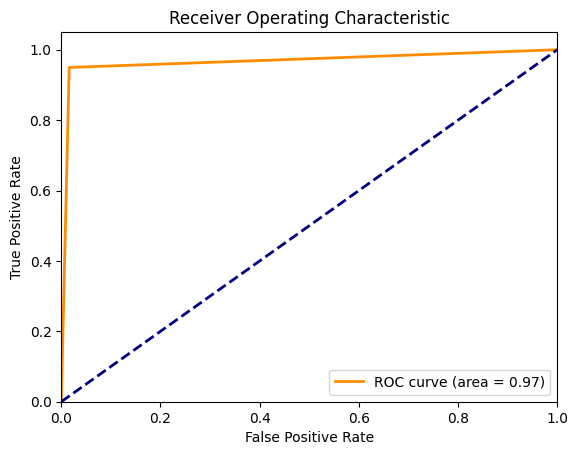

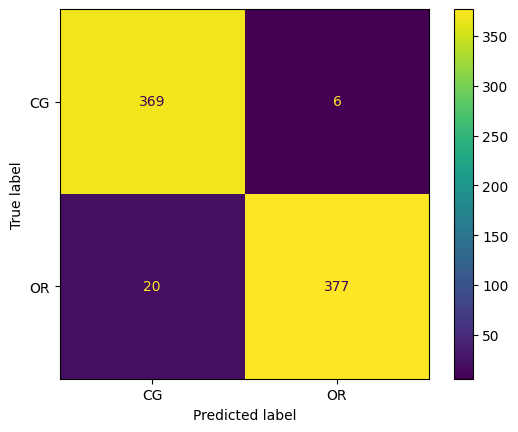

eval_loss: 0.1882675588130951
eval_accuracy: 0.966321243523316
eval_f1: 0.9666666666666668
eval_precision: 0.9843342036553525
eval_recall: 0.9496221662468514
eval_runtime: 14.9612
eval_samples_per_second: 51.6
eval_steps_per_second: 0.468
epoch: 3.0
Category Pet_Supplies_5


Step,Training Loss


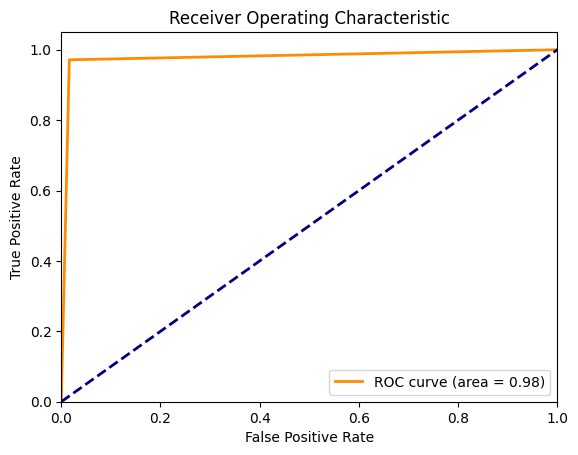

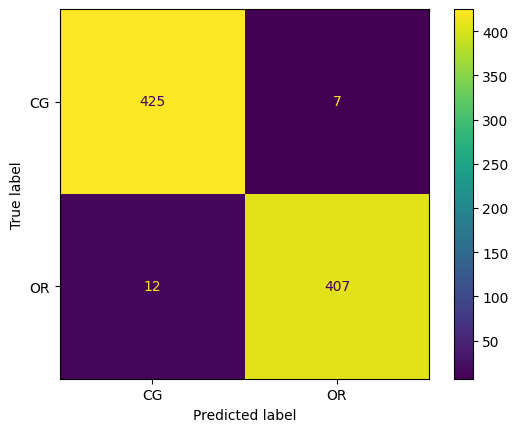

eval_loss: 0.08548925817012787
eval_accuracy: 0.9776733254994124
eval_f1: 0.9771908763505401
eval_precision: 0.9830917874396136
eval_recall: 0.9713603818615751
eval_runtime: 14.9386
eval_samples_per_second: 56.966
eval_steps_per_second: 0.469
epoch: 3.0
Category Kindle_Store_5


Step,Training Loss


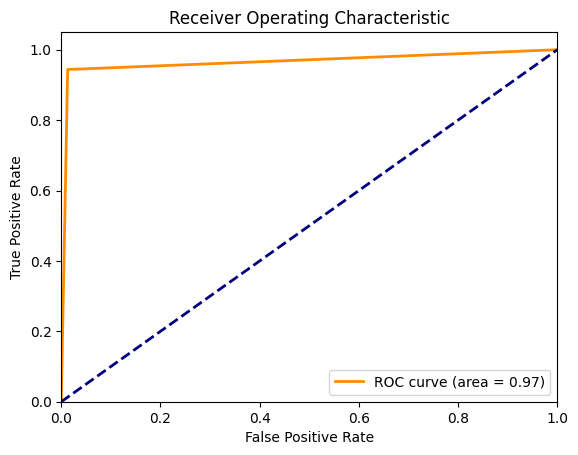

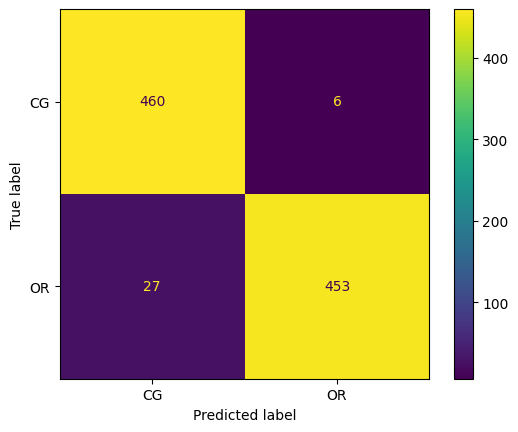

eval_loss: 0.1643441915512085
eval_accuracy: 0.9651162790697675
eval_f1: 0.9648562300319489
eval_precision: 0.9869281045751634
eval_recall: 0.94375
eval_runtime: 16.5802
eval_samples_per_second: 57.056
eval_steps_per_second: 0.483
epoch: 3.0
Category Books_5


Step,Training Loss


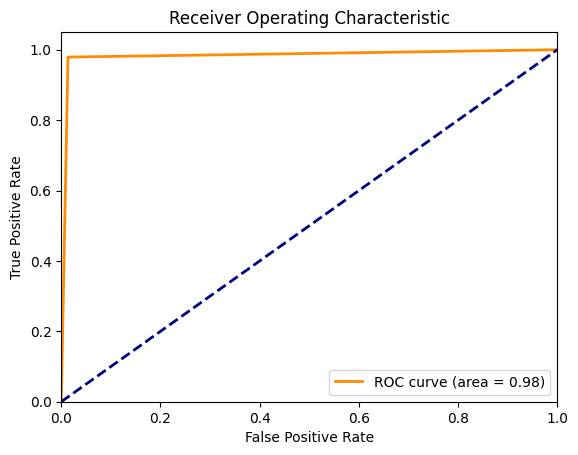

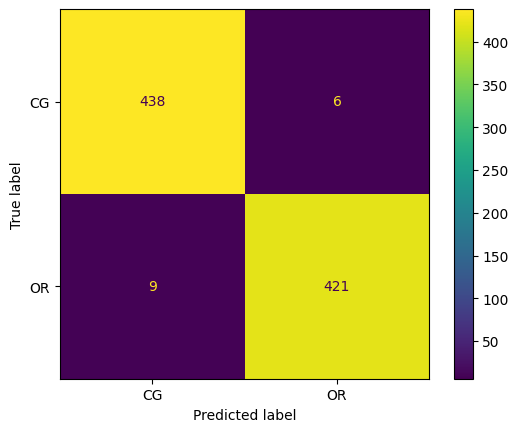

eval_loss: 0.05707511678338051
eval_accuracy: 0.982837528604119
eval_f1: 0.9824970828471411
eval_precision: 0.9859484777517564
eval_recall: 0.9790697674418605
eval_runtime: 18.3963
eval_samples_per_second: 47.51
eval_steps_per_second: 0.381
epoch: 3.0
Category Toys_and_Games_5


Step,Training Loss


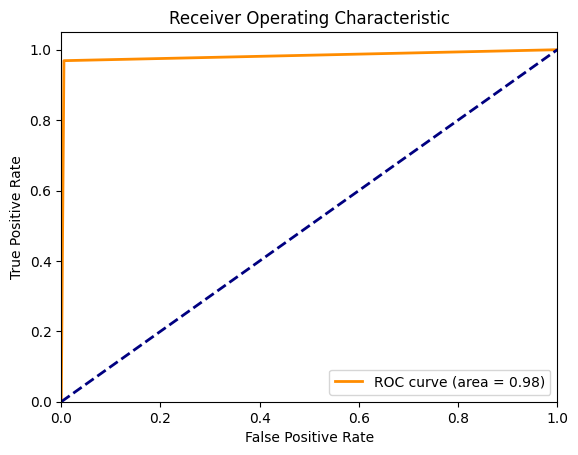

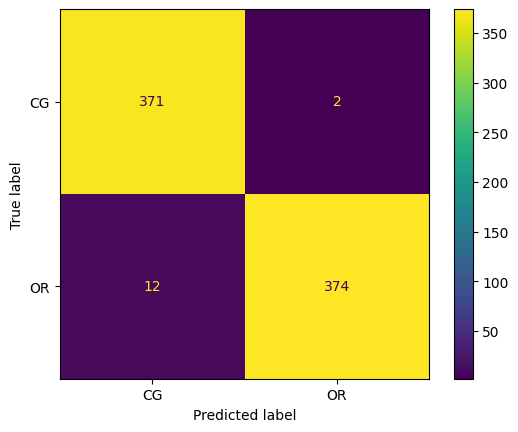

eval_loss: 0.08349557965993881
eval_accuracy: 0.9815546772068511
eval_f1: 0.9816272965879265
eval_precision: 0.9946808510638298
eval_recall: 0.9689119170984456
eval_runtime: 13.1608
eval_samples_per_second: 57.671
eval_steps_per_second: 0.456
epoch: 3.0
Category Clothing_Shoes_and_Jewelry_5


Step,Training Loss


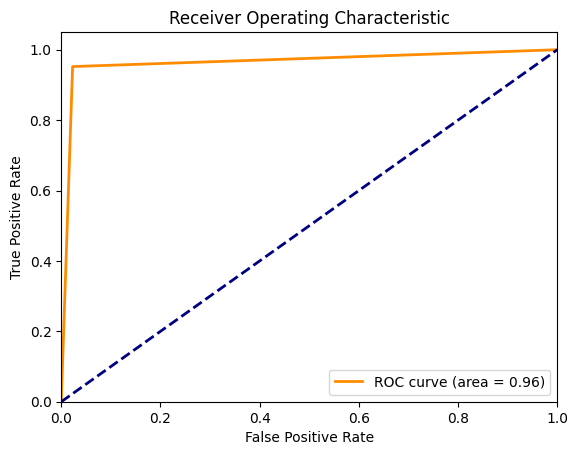

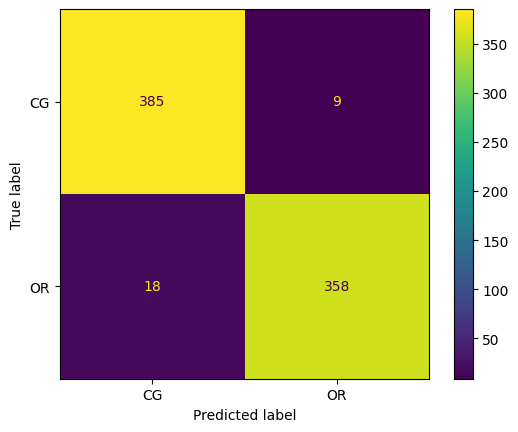

eval_loss: 0.17926710844039917
eval_accuracy: 0.964935064935065
eval_f1: 0.9636608344549125
eval_precision: 0.9754768392370572
eval_recall: 0.9521276595744681
eval_runtime: 14.9715
eval_samples_per_second: 51.431
eval_steps_per_second: 0.468
epoch: 3.0


In [22]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    lb = LabelBinarizer()
    lb.fit(labels)
    labels = lb.transform(labels)
    preds = lb.transform(preds)


    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute the confusion matrix
    conf_mat = confusion_matrix(labels, preds)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=le.classes_)
    disp.plot()
    plt.show()
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }

# your data
df = pd.read_csv('/kaggle/input/fake-reviews-data/fake reviews dataset.csv')


# List of categories
categories = df['category'].unique()

# Initialize the LabelEncoder
le = LabelEncoder()

class FakeReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx].unsqueeze(0)  # Add an extra dimension
        return item

    def __len__(self):
        return len(self.labels)
    
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

if not tokenizer.pad_token:
    tokenizer.pad_token = tokenizer.eos_token

# Create the Trainer
training_args = TrainingArguments(
    output_dir='bertresults',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='bertlogs',
)

# Loop over each category
for category in categories:
    # Filter data for the current category
    print("Category",category)
    df_filtered = df[df['category'] == category]

    # Split your data into training and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(df_filtered['text_'], df_filtered['label'], test_size=0.2, random_state=42)

    # Fit and transform the labels
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    # Now you can convert your labels to tensors
    train_labels = torch.from_numpy(train_labels)
    test_labels = torch.from_numpy(test_labels)

    train_texts = train_texts.tolist()
    test_texts = test_texts.tolist()

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    test_encodings = tokenizer(test_texts, truncation=True, padding=True)

    train_dataset = FakeReviewDataset(train_encodings, train_labels)
    test_dataset = FakeReviewDataset(test_encodings, test_labels)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # use the function defined in the previous step
    )

    # Train the model
    trainer.train()
    metrics = trainer.evaluate()
    # Print the metrics
    for key, value in metrics.items():
        print(f"{key}: {value}")